### Convert the files to nrrd

In [ ]:
import os
import pydicom
import SimpleITK as sitk


class DICOMConverter:
    def __init__(self, root_directory, output_dir, pattern):
        self.root_directory = root_directory
        self.output_dir = output_dir
        self.pattern = pattern

    def read_dicom_series(self, directory):
        """
        Reads a DICOM series from the specified directory and returns it as a SimpleITK image.
        
        Parameters:
            directory (str): The directory containing the DICOM series.
            
        Returns:
            sitk.Image: The SimpleITK image object.
        """
        reader = sitk.ImageSeriesReader()
        dicom_names = reader.GetGDCMSeriesFileNames(directory)
        reader.SetFileNames(dicom_names)
        image = reader.Execute()
        return image

    def convert_dicom_to_nrrd(self, dicom_dir, output_file):
        """
        Converts a DICOM series to an NRRD file and saves it.
        
        Parameters:
            dicom_dir (str): The directory containing the DICOM series.
            output_file (str): The path to save the NRRD file.
        """
        image = self.read_dicom_series(dicom_dir)
        corrected_image = self.correct_intensity_inhomogeneity(image)
        
        #######################################################   Uncomment for using the Curvature flow denoizer
        denoised_image = self.denoise_image(corrected_image)
        #######################################################
        
        sitk.WriteImage(denoised_image, output_file)

    def find_dicom_subdirectories(self):
        """
        Finds subdirectories in the root directory that match the pattern and lists their subdirectories.
        
        Returns:
            dict: A dictionary where keys are paths to directories matching the pattern, and values are lists of subdirectories.
        """
        matched_directories = {}
        for dirpath, dirnames, filenames in os.walk(self.root_directory):
            for dirname in dirnames:
                if self.pattern in dirname:
                    full_path = os.path.join(dirpath, dirname)
                    subdirs = [os.path.join(full_path, d) for d in os.listdir(
                        full_path) if os.path.isdir(os.path.join(full_path, d))]
                    matched_directories[full_path] = subdirs
                    #break
        return matched_directories

    def correct_intensity_inhomogeneity(self, image):
        """
        Corrects intensity inhomogeneity in the given SimpleITK image using N4ITK bias field correction.
        
        Parameters:
            image (sitk.Image): The input SimpleITK image.
            
        Returns:
            sitk.Image: The corrected SimpleITK image.
        """
        # Cast image to a supported type
        image = sitk.Cast(image, sitk.sitkFloat32)

        # Perform bias field correction
        corrector = sitk.N4BiasFieldCorrectionImageFilter()
        corrected_image = corrector.Execute(image)
        return corrected_image

    def denoise_image(self, image):
        """
        Denoises the given SimpleITK image using CurvatureFlowImageFilter.
        
        Parameters:
            image (sitk.Image): The input SimpleITK image.
            
        Returns:
            sitk.Image: The denoised SimpleITK image.
        """
        # Apply curvature flow image filter for denoising
        smoother = sitk.CurvatureFlowImageFilter()
        smoother.SetTimeStep(0.125)
        smoother.SetNumberOfIterations(5)
        denoised_image = smoother.Execute(image)
        return denoised_image

    def process_directories(self):
        """
        Processes the matched directories and converts DICOM series to NRRD files.
        
        Parameters:
            output_dir (str): The directory to save the NRRD files.
        """
        dicom_subdirectories = self.find_dicom_subdirectories()

        for main_dir, sub_dirs in dicom_subdirectories.items():
            print(f"Main directory: {main_dir}")
            for sub_dir in sub_dirs:
                print(f"  Subdirectory: {sub_dir}")
                path_components = os.path.normpath(sub_dir).split(os.sep)
                parent_folder = path_components[1]
                sub_folder = os.path.basename(sub_dir)
                output_filename = os.path.join(
                    self.output_dir, f"{parent_folder}_{sub_folder}.nrrd")
                print(f"Output filename: {output_filename}")
                self.convert_dicom_to_nrrd(sub_dir, output_filename)
                #break  # Assuming you only want to process the first subdirectory


# Example usage
root_directory = ['./Raw/P1/','./Raw/P2/','./Raw/P3/','./Raw/P4/','./Raw/P5/','./Raw/P6/','./Raw/P6/','./Raw/P7/', './Raw/P8/','./Raw/P9/','./Raw/P10/']
output_dir = './NRRD_Files_N4Bias_Denoised/'
pattern ='DCM_3D'

for directory in root_directory:
    converter = DICOMConverter(directory, output_dir, pattern)
    converter.process_directories()


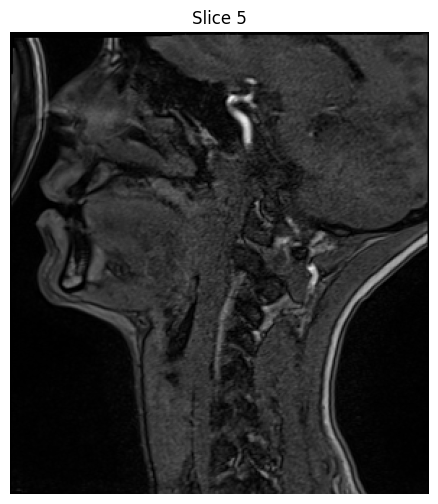

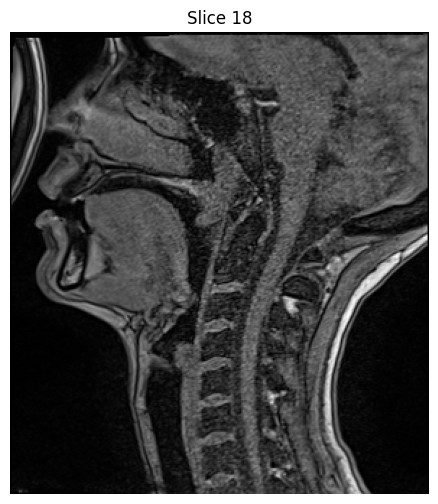

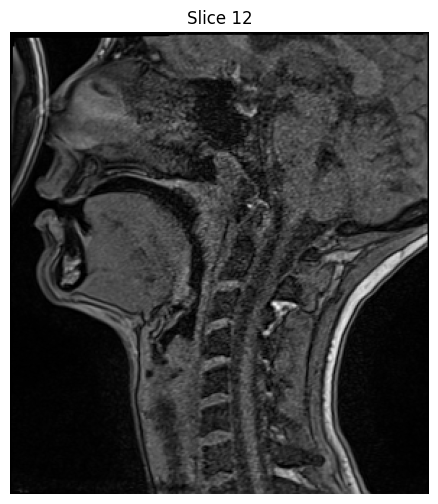

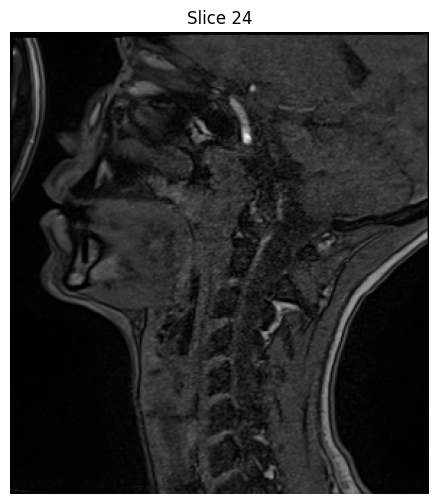

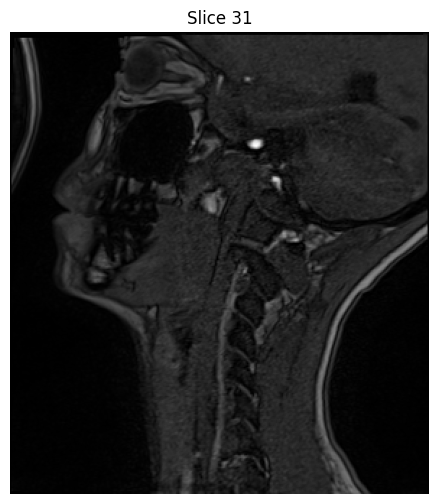

In [3]:
import SimpleITK as sitk
import matplotlib.pyplot as plt

# Function to read NRRD file


def read_nrrd(file_path):
    image = sitk.ReadImage(file_path)
    array = sitk.GetArrayFromImage(image)
    return array

# Function to display a slice from the 3D image


def display_slice(image_array, slice_index):
    plt.figure(figsize=(6, 6))
    plt.imshow(image_array[slice_index], cmap='gray')
    plt.title(f'Slice {slice_index}')
    plt.axis('off')
    plt.show()


# Specify the path to the NRRD file
nrrd_file = './NRRD_Files_N4Bias_Denoised/P7_sh2.nrrd'

# Read the NRRD file
image_array = read_nrrd(nrrd_file)

# Display a few slices from the 3D image
# You can change the indices to display different slices
display_slice(image_array, 5)  # First third slice
display_slice(image_array, image_array.shape[0] // 2)  # Middle slice
display_slice(image_array, image_array.shape[0] // 3)  # First third slice
# Second third slice
display_slice(image_array, (2 * image_array.shape[0]) // 3)
display_slice(image_array, 31)
